In [0]:
!pip -q install python_speech_features

  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 57kB/s 
     |████████████████████████████████| 3.1MB 34.1MB/s 
     |████████████████████████████████| 501kB 37.3MB/s 


In [0]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


##  Get Scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/analysisFunctions.py

## Download Data

In [0]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Nothing to do.
Nothing to do.


In [0]:
from getData import getDataframe

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'], include_unknown=False)
testDF = getDataframe(dataDict['test'], include_unknown=False) 
finalTestDF = getDataframe(dataDict['finalTest'], include_unknown=False)

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))
print("Final test files: {}".format(testDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835
Final test files: 6835


## Autoencoder

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Reshape, BatchNormalization,MaxPooling2D, UpSampling2D, Activation, Dropout, Flatten, GlobalAveragePooling2D, ZeroPadding2D, Cropping2D

def getAutoencoder(input_shape = (99,40)):
    
    model = Sequential()
    
    model.add(Reshape(input_shape=(99,40), target_shape=(99, 40, 1), name='ReshapeInput'))
    model.add(ZeroPadding2D(((1,0), (0,0))))
    
    model.add(Conv2D(32, (10, 1) , padding='same', activation='linear'))
    model.add(Conv2D(32, (1, 5) , padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(5,2)))
    
    model.add(Conv2D(32, (3, 3) , padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2,2))) 
    
    model.add(Conv2D(16, (3, 3) , padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2,2))) 
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(64 , activation='linear', name='ENCODED'))
    model.add(Dropout(0.2))
    model.add(Dense(400 , activation='tanh'))
    model.add(Reshape((5, 5, 16)))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(16, (3, 3) , padding='same', activation='tanh'))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3) , padding='same', activation='tanh'))
    
    model.add(UpSampling2D((5, 2)))
    model.add(Conv2D(32, (1, 5) , padding='same', activation='tanh'))
    model.add(Conv2D(32, (10, 1) , padding='same', activation='linear'))
    
    model.add(Conv2D(1,(3, 3), padding='same', activation='linear'))
   
   
    model.add(Cropping2D(((1,0), (0,0))))
    model.add(Reshape(target_shape=(99, 40)))
    return model    

model = getAutoencoder()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ReshapeInput (Reshape)       (None, 99, 40, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 100, 40, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 40, 32)       352       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 40, 32)       5152      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0

In [0]:
from trainingUtils import _loadWavs, _logMelFilterbank, getDataset
from python_speech_features import mfcc
import numpy as np

def _normalize(data):
    """
    Normalize feature vectors
    """
    mean = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    return (data - mean) / (sd+1e-08)

def _scale(data):
    """
    Scale input values in range [0,1]
    """
    min_value, max_value = np.min(data, axis=0), np.max(data, axis=0)
    scaled = (data - min_value) / (max_value - min_value + 1e-08)
    return scaled

def _parse_fn_autoencoder(filename, label, nfilt=40, add_noise=True, scale=True):
    """
    Function used to compute filterbanks from file name
    """
    wave = _loadWavs(filename.numpy())
    fbank = _logMelFilterbank(wave, nfilt)
    #fbank = mfcc(wave)
    
    if scale:
        fbank = _scale(fbank)
    
    input_image = fbank
    if add_noise:
        input_image = fbank + 0.5*np.random.normal(0, 1, fbank.shape)
        
    return input_image, fbank

In [0]:
import os

def getDatasetAutoencoder(df, batch_size, cache_file=None, shuffle=True, nfilt=40, add_noise=False, scale=False):
    """
    Return a tf.data.Dataset containg filterbanks, labels
    """
    data = tf.data.Dataset.from_tensor_slices(
        (df['files'].tolist(), df['labels'].tolist())
    )

    data = data.map(
        lambda filename, label: tuple(
            tf.py_function(_parse_fn_autoencoder, inp=[filename, label, nfilt, add_noise, scale], Tout=[tf.float32, tf.float32])
        ),
        num_parallel_calls=os.cpu_count()
    )

    if cache_file:
        data = data.cache(cache_file)

    if shuffle:
        data = data.shuffle(buffer_size=df.shape[0])

    data = data.batch(batch_size).prefetch(buffer_size=2)

    steps = df.shape[0] // batch_size

    return data, steps

In [0]:
!rm train_den* val_den*

In [0]:
BATCH_SIZE = 32
# Reduced trainign dataset
NUM_EXAMPLES = 20000

train_data, train_steps = getDatasetAutoencoder(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_denoising_autoencoder_cache',
    shuffle=True,
    add_noise=True,
    scale=True
) 

val_data, val_steps = getDatasetAutoencoder(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_denoising_autoencoder_cache',
    shuffle=False,
    add_noise=False,
    scale=True
)

In [0]:
model.compile(loss='mse', 
              optimizer=tf.keras.optimizers.Adam()
             )

In [10]:
EPOCHS = 80

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=1)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

# Save best models
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("bestDenoisingAE.h5",  monitor='val_loss', save_best_only=True)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR, modelCheckpoint])

W0708 18:07:27.325420 139811129743104 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0708 18:07:27.328735 139810093831936 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0708 18:07:27.332160 139810093831936 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0708 18:07:27.334831 139810093831936 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0708 18:07:27.329366 139811129743104 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32


Epoch 1/80
625/625 [==============================] - 142s 228ms/step - loss: 0.0296 - val_loss: 0.0642
Epoch 2/80
625/625 [==============================] - 29s 46ms/step - loss: 0.0210 - val_loss: 0.0381
Epoch 3/80
625/625 [==============================] - 29s 46ms/step - loss: 0.0194 - val_loss: 0.0262
Epoch 4/80
625/625 [==============================] - 29s 46ms/step - loss: 0.0186 - val_loss: 0.0215
Epoch 5/80
625/625 [==============================] - 29s 46ms/step - loss: 0.0182 - val_loss: 0.0182
Epoch 6/80
625/625 [==============================] - 29s 46ms/step - loss: 0.0179 - val_loss: 0.0163
Epoch 7/80
625/625 [==============================] - 29s 46ms/step - loss: 0.0175 - val_loss: 0.0154
Epoch 8/80
625/625 [==============================] - 28s 45ms/step - loss: 0.0173 - val_loss: 0.0155
Epoch 9/80
625/625 [==============================] - 28s 46ms/step - loss: 0.0171 - val_loss: 0.0144
Epoch 10/80
625/625 [==============================] - 29s 46ms/step - loss: 0.0

In [0]:
model.save("denoisingAE.h5")

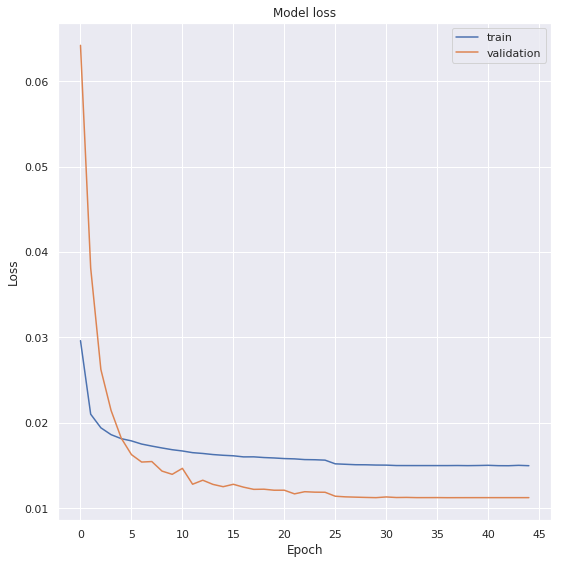

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns 

sns.set()

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax1 = plt.subplots(1,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

plt.tight_layout()
fig.show()

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir /content/gdrive/My\ Drive/speechRecognition/DenoisingAutoencoders

In [23]:
GDRIVE_PATH = "/content/gdrive/My Drive/speechRecognition/DenoisingAutoencoders/"

model.save(GDRIVE_PATH +"denoisingAE.h5")
print("Saved model to drive")

Saved model to drive


In [24]:
import pickle
## Save history data
with open(GDRIVE_PATH + "train_results.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved training history to drive


## Test 

In [0]:
from tensorflow.keras.models import load_model

autoencoder = load_model("bestDenoisingAE.h5")

In [0]:
def _parse_fn_autoencoder_test(filename, label, nfilt=40, add_noise=True, scale=True):
    """
    Function used to compute filterbanks from file name
    """
    wave = _loadWavs(filename)
    fbank = _logMelFilterbank(wave, nfilt)
    #fbank = mfcc(wave)
    
    if scale:
        fbank = _scale(fbank)
    
    input_image = fbank
    if add_noise:
        input_image = fbank + 0.2*np.random.normal(0, 1, fbank.shape)
        
    return input_image, fbank

In [0]:
image_noise, image = _parse_fn_autoencoder_test(testDF['files'][100], testDF['files'][100])
denoised = model.predict(image_noise.reshape((1,99,40))).reshape((99,40))

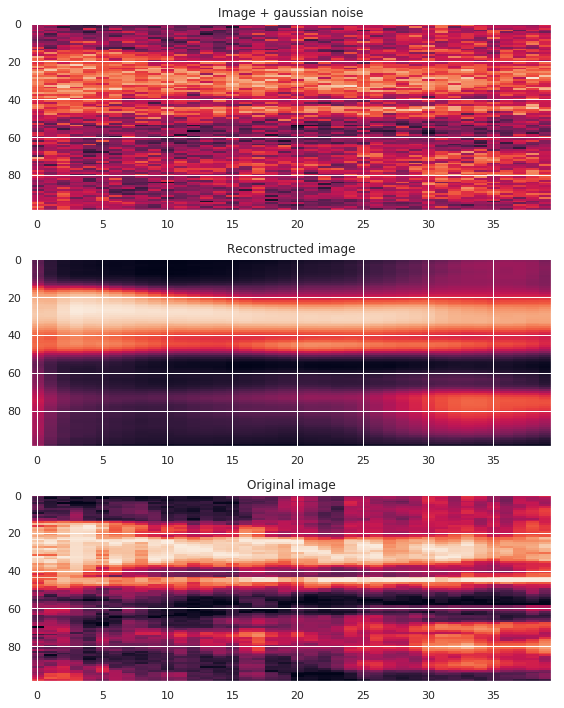

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,10))

ax1.imshow(image_noise, aspect="auto")
ax1.set_title("Image + gaussian noise")

ax2.imshow(denoised, aspect="auto")
ax2.set_title("Reconstructed image")

ax3.imshow(image, aspect="auto")
ax3.set_title("Original image")

plt.tight_layout()
plt.show()

In [0]:
def getFeatures(model, data):
    layer_name = 'ENCODED'
    layer_out = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return layer_out.predict(data, use_multiprocessing=True)